# Tecton Testing

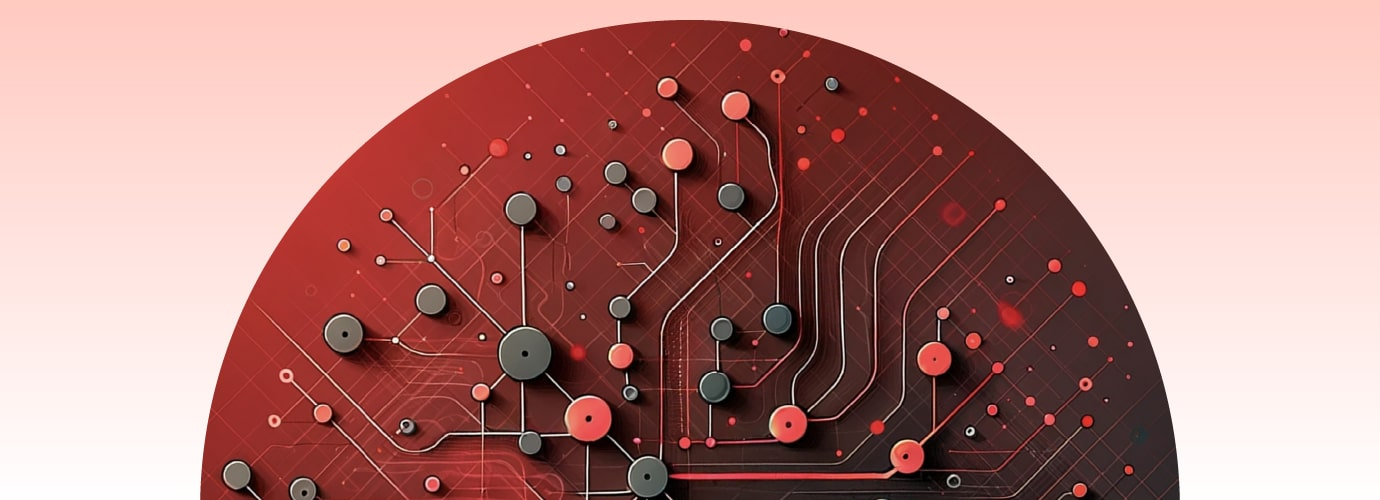

This notebook sets up a Tecton with Rift in Colab and provides a demonstration on using interactive testing and testing in production with Tecton features. You will need a Tecton account with Rift in order to run this notebook, to sign up please see more information on [this page](https://resources.tecton.ai/rift). ***This notebook will not materialize any Tecton Feature Views or Feature Services that will incur costs to your Tecton account.***

## Setting up Tecton with Rift in Colab
The cell below installs Tecton on Colab and sets up the directories and files we will need to run Tecton tests.

The two cells following that use IPython libraries to finish setup. One restarts the Colab kernel so the you enviornment can access the newly installed Tecton (feel free to ignore a colab error message that may pop up in the bottom lefthand corner after executing this cell). The other IPython will allow you to both execute a cell's code and save it as a file for unit testing.

Finally, the last two cells in this section login to Tecton. You can request a Tecton account with Rift [here](https://resources.tecton.ai/rift).

In [ ]:
!pip install virtualenv
!virtualenv tecton
!source tecton/bin/activate
!pip install 'tecton[rift]==0.8.0rc1'
!mkdir tecton-testing
%cd tecton-testing
!mkdir features
!mkdir tests
!touch ./features/transaction_amount_is_high.py
!touch ./tests/transaction_amount_is_high.py
!tecton init

In [ ]:
# Restart kernel after installs so that your environment can access the new packages
import IPython
import time

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

In [ ]:
# This cell allows us to both run Tecton feature definitions interactively
# and save feature definitions to test in production
from IPython.core.magic import register_cell_magic
@register_cell_magic
def run_and_save(line, cell):
    with open(line, 'wt') as fd:
        fd.write(cell)
    code = compile(cell, line, 'exec')
    exec(code, globals())

In [ ]:
import tecton
tecton.login('YOUR-RIFT-ACCOUNT.tecton.ai')
%cd tecton-testing

In [ ]:
!tecton login --manual YOUR-RIFT-ACCOUNT.tecton.ai
!tecton workspace create tecton-testing

## Interactive Testing of Tecton Features
In this section, a Tecton feature is defined and tested immediately after with the `run()` command


In [ ]:
%%run_and_save ./features/transaction_amount_is_high.py

from tecton import RequestSource, on_demand_feature_view
from tecton.types import Field, Float64, Int64
import pandas

# Define the request schema
transaction_request = RequestSource(schema=[Field("amount", Float64)])

# Define the output schema
output_schema = [Field("transaction_amount_is_high", Int64)]

# This On-Demand Feature View evaluates a transaction amount and declares it as "high", if it's higher than 10000
@on_demand_feature_view(
    sources=[transaction_request],
    mode="pandas",
    schema=output_schema,
    name="transaction_amount_is_high",
    description="Whether the transaction amount is considered high (over $10000)",
)
def transaction_amount_is_high(transaction_request: pandas.DataFrame):
    import pandas as pd

    df = pd.DataFrame()
    df["transaction_amount_is_high"] = (transaction_request["amount"] >= 10000).astype("int64")
    return df

In [ ]:
transaction_amount_is_high.validate()

transaction_request = pandas.DataFrame([{"amount": 100.0}])

result = transaction_amount_is_high.run(
    transaction_request=transaction_request,
)
print(result.to_pandas())

transaction_request = pandas.DataFrame([{"amount": 100000.0}])

result = transaction_amount_is_high.run(
    transaction_request=transaction_request,
)
print(result.to_pandas())

## Unit Testing and Tecton feature variants
This section defines and runs a unit test, `test_transaction_amount_is_high`, that tests the feature that was just built. There was a mistake in the feature definition, however, that is causing the unit test to fail!

The feature you build deems a transaction as high if it is above 10000, but we actually meant that number to be 5000, the cells below create a variant of the previous Feature View definition, update the amount, and rerun the unit test.


In [ ]:
%%run_and_save ./tests/transaction_amount_is_high.py
from features.transaction_amount_is_high import transaction_amount_is_high
import pandas

# Testing the 'transaction_amount_is_high' feature which depends on request data ('amount') as input
def test_transaction_amount_is_high():
    transaction_request = pandas.DataFrame({"amount": [124, 5001, 34235436234]})

    actual = transaction_amount_is_high.test_run(transaction_request=transaction_request)
    expected = pandas.DataFrame({"transaction_amount_is_high": [0, 1, 1]})

    pandas.testing.assert_frame_equal(actual, expected)

In [ ]:
# It is okay if this cell produces an error,
# You will be fixing this error in cells following

test_transaction_amount_is_high()

In [ ]:
%%run_and_save ./features/transaction_amount_is_high.py

from tecton import RequestSource, on_demand_feature_view
from tecton.types import Field, Float64, Int64
import pandas

# Define the request schema
transaction_request = RequestSource(schema=[Field("amount", Float64)])

# Define the output schema
output_schema = [Field("transaction_amount_is_high", Int64)]

# This On-Demand Feature View evaluates a transaction amount and declares it as "high", if it's higher than $5,000
@on_demand_feature_view(
    sources=[transaction_request],
    mode="pandas",
    schema=output_schema,
    name="transaction_amount_is_high:v2",
    description="Whether the transaction amount is considered high (over $5000)",
)
def transaction_amount_is_high(transaction_request: pandas.DataFrame):
    import pandas as pd

    df = pd.DataFrame()
    df["transaction_amount_is_high"] = (transaction_request["amount"] >= 5000).astype("int64")
    return df

In [ ]:
transaction_amount_is_high.validate()

In [ ]:
test_transaction_amount_is_high()

## Wrapping up

Unit tests can run interactively, or as a CLI command that can be included in a CI/CD environment, the cell below reruns the unit tests as a CLI command, then the workspace used for this notebook is deleted.

In [ ]:
!tecton test

In [ ]:
!tecton workspace delete tecton-testing